In [2]:
import json
import logging
import os
from typing import List

import numpy as np
import pandas as pd
import pandas_gbq
import plotly.graph_objects as go
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 


ROOT_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(ROOT_DIR)
#ROOT_DIR = os.path.realpath(os.path.join(os.path.dirname(__file__), ".."))
#LOG_PATH = os.path.join(ROOT_DIR, "logs/forecasting.log")
#logging.basicConfig(filename=LOG_PATH, encoding="utf-8", level=logging.DEBUG)


def _get_query_string(query_name: str):
    """
    Get a query from the queries folder, as a string
    :param query_name: The name of the query to use, without the .sql extension
    :return: The query as a string
    """
    with open(os.path.join(ROOT_DIR, f"queries/{query_name}.sql"), "r") as f:
        return f.read()


def _substitute_asin(query: str, asins: List[str] = None):
    """
    Create a where in clause from a list of ASINs
    :param query: The query to use as a string
    :param asins: The brands to filter by, as a list of strings
    :return: The query string with the where in clause
    """
    where = f" and asin in unnest({asins})" if asins else ""
    return query.replace("ASIN_SELECTION", where)


def get_calendar():
    calendar = _get_query_string("calendar")
    calendar_df, _ = _get_data_from_bq(calendar)
    return calendar_df


def _get_data_from_bq(query: str,):
    """
    Get data from BigQuery, using a query string
    :param query: The query to use
    :return: A pandas DataFrame
    """
    return pandas_gbq.read_gbq(query, project_id="yaba-data"), query

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-01f2h2tf because the default path (/home/docker/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
dataset = _get_data_from_bq(_get_query_string("everything_asin"))
print(dataset)

/usr/local/lib/python3.11/site-packages/google/cloud/bigquery/table.py:2230: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


(       seller_region country_code   brand        asin reporting_date  \
0                 eu         None  velmia  B09YRMK3GW     2023-12-07   
1                 eu         None  velmia  B09YRMK3GW     2023-11-22   
2                 eu         None  velmia  B09YRMK3GW     2023-11-29   
3                 eu         None  velmia  B09YRMK3GW     2023-12-10   
4                 eu         None  velmia  B09YRMK3GW     2023-11-19   
...              ...          ...     ...         ...            ...   
888715            na           us  lonbet  B0B4X4MGQG     2023-12-05   
888716            na           us  lonbet  B0B4X4MGQG     2023-11-14   
888717            na           us  lonbet  B0B4X4MGQG     2023-12-18   
888718            na           us  lonbet  B0B4X4MGQG     2023-11-22   
888719            na           us  lonbet  B0B4X4MGQG     2023-11-24   

        top_bsr_position  bot_bsr_position        sales  performance  units  \
0                    NaN               NaN         None

In [9]:
data_top10 = pd.read_csv("../data/top10_data.csv")
last_year = pd.read_csv("../data/3month.csv")

In [5]:
data_top10.columns
data_top10.info

<bound method DataFrame.info of      seller_region country_code             brand        asin reporting_date  \
0               eu           uk  incite-nutrition  B00RXIIW7K     2023-10-02   
1               eu           uk  incite-nutrition  B00RXIIW7K     2023-11-15   
2               eu           uk  incite-nutrition  B00RXIIW7K     2023-12-15   
3               eu           uk  incite-nutrition  B00RXIIW7K     2023-10-22   
4               eu           uk  incite-nutrition  B00RXIIW7K     2023-11-13   
...            ...          ...               ...         ...            ...   
1876            na           us       igan-covers  B0817GWV8C     2023-09-17   
1877            na           us       igan-covers  B0817GWV8C     2023-11-14   
1878            na           us       igan-covers  B0817GWV8C     2023-06-06   
1879            na           us       igan-covers  B0817GWV8C     2023-10-24   
1880            na           us       igan-covers  B0817GWV8C     2023-10-12   

      t

In [6]:
data_top10.describe

<bound method NDFrame.describe of      seller_region country_code             brand        asin reporting_date  \
0               eu           uk  incite-nutrition  B00RXIIW7K     2023-10-02   
1               eu           uk  incite-nutrition  B00RXIIW7K     2023-11-15   
2               eu           uk  incite-nutrition  B00RXIIW7K     2023-12-15   
3               eu           uk  incite-nutrition  B00RXIIW7K     2023-10-22   
4               eu           uk  incite-nutrition  B00RXIIW7K     2023-11-13   
...            ...          ...               ...         ...            ...   
1876            na           us       igan-covers  B0817GWV8C     2023-09-17   
1877            na           us       igan-covers  B0817GWV8C     2023-11-14   
1878            na           us       igan-covers  B0817GWV8C     2023-06-06   
1879            na           us       igan-covers  B0817GWV8C     2023-10-24   
1880            na           us       igan-covers  B0817GWV8C     2023-10-12   

     

In [7]:
data_top10['reporting_date'] = pd.to_datetime(data_top10['reporting_date'])


In [8]:
data_top10['Month'] = data_top10['reporting_date'].dt.month
data_top10['Year'] = data_top10['reporting_date'].dt.year
data_top10['Date MonthYear'] = data_top10['reporting_date'].dt.strftime('%Y-%m')
#data_top10 = data_top10.drop(columns=['reporting_date'])

In [10]:
last_year['reporting_date'] = pd.to_datetime(last_year['reporting_date'])
last_year['Month'] = last_year['reporting_date'].dt.month
last_year['Year'] = last_year['reporting_date'].dt.year
last_year['Date MonthYear'] = last_year['reporting_date'].dt.strftime('%Y-%m')

In [9]:
data_top10.head()

,seller_region,country_code,brand,asin,reporting_date,top_bsr_position,bot_bsr_position,sales,performance,units,...,pageviews_sde1,topbsr_units,botbsr_units,units_units,refunds_units,sessionsmobile_units,pageviews_units,Month,Year,Date MonthYear
0,eu,uk,incite-nutrition,B00RXIIW7K,2023-10-02,3.0,16.0,2817.04,1.000000,325.0,...,1.217804,0.009231,0.049231,1.0,-0.151692,1.135385,2.996923,10,2023,2023-10
1,eu,uk,incite-nutrition,B00RXIIW7K,2023-11-15,4.0,33.0,4436.46,1.150273,515.0,...,1.470796,0.007767,0.064078,1.0,-0.182155,1.273786,3.238835,11,2023,2023-11
2,eu,uk,incite-nutrition,B00RXIIW7K,2023-12-15,2.0,32.0,3444.11,0.898320,460.0,...,1.666155,0.004348,0.069565,1.0,-0.129152,1.054348,2.715217,12,2023,2023-12
3,eu,uk,incite-nutrition,B00RXIIW7K,2023-10-22,2.0,31.0,3973.09,1.034317,462.0,...,1.445392,0.004329,0.067100,1.0,-0.068658,1.283550,2.930736,10,2023,2023-10
4,eu,uk,incite-nutrition,B00RXIIW7K,2023-11-13,4.0,42.0,3417.13,0.916657,396.0,...,1.113257,0.010101,0.106061,1.0,-0.053965,1.136364,2.896465,11,2023,2023-11


In [11]:
df = data_top10
df2 = last_year
df.isnull().sum()

seller_region             0
country_code              0
brand                     0
asin                      0
reporting_date            0
top_bsr_position          0
bot_bsr_position          0
sales                    11
performance              11
units                    11
discounts                 0
cogs                     11
refunds                 394
sde1                      0
sessions_mobile          25
sessions_browser         25
sessions                 25
pageviews_mobile         25
pageviews_browser        25
pageviews                25
topbsr_sales             11
botbsr_sales             11
units_sales              11
refunds_sales           398
sessionsmobile_sales     26
pageviews_sales          26
topbsr_sde1               6
botbsr_sde1               6
units_sde1               11
refunds_sde1            394
sessionsmobile_sde1      25
pageviews_sde1           25
topbsr_units             11
botbsr_units             11
units_units              11
refunds_units       

In [11]:
# Display total values of all country 
pd.set_option('display.max_rows', None)
df['country_code'].value_counts()

country_code
us    1254
uk     627
Name: count, dtype: int64

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later



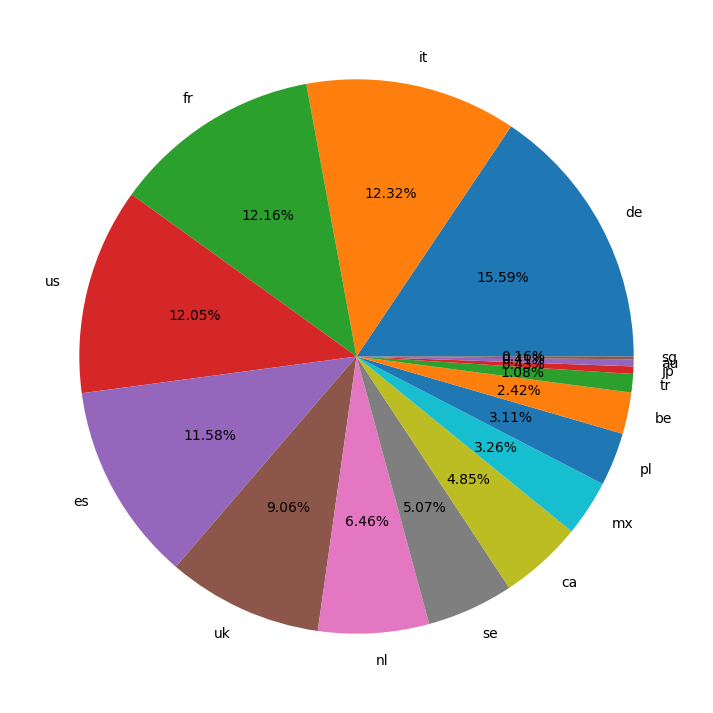

In [44]:
country_names = last_year.country_code.value_counts().index
country_val = last_year.country_code.value_counts().values
# Pie Chart for top 20 country
fig,ax = plt.subplots(figsize=(9,9))
ax.pie(country_val[:20],labels=country_names[:20],autopct='%1.2f%%')
plt.show()

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword ar

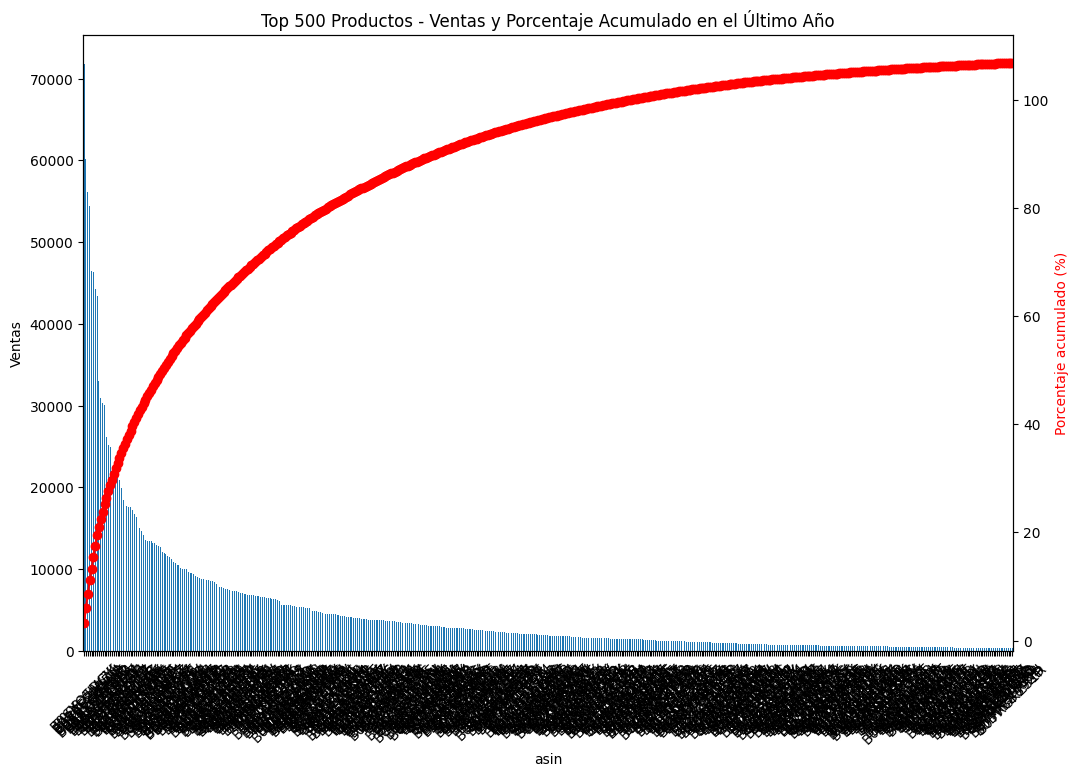

In [15]:
import matplotlib.pyplot as plt

# ... (código de preparación de datos)

# Limitar a los top N productos para mejorar la visualización
top_n = 500
ventas_top = ventas_por_producto.head(top_n)

# Graficar
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

# Barra de ventas
ventas_top.plot(kind='bar', x='asin', y='sde1', ax=ax1, legend=False, rot=45)
ax1.set_ylabel('Ventas')

# Línea de porcentaje acumulado
ventas_top.plot(x='asin', y='porcentaje_acumulado', color='red', ax=ax2, marker='o', legend=False)
ax2.set_ylabel('Porcentaje acumulado (%)', color='red')

plt.title(f'Top {top_n} Productos - Ventas y Porcentaje Acumulado en el Último Año')
plt.show()

In [43]:
print(len(ventas_por_producto['asin'].unique()))

3287


In [42]:
import plotly.express as px
import plotly.graph_objects as go

# ... (código de preparación de datos)
productos_positivos = ventas_por_producto.groupby('asin')['sde1'].sum().loc[lambda x: x > 0].index
ventas_por_producto_filtrado = ventas_por_producto[ventas_por_producto['asin'].isin(productos_positivos)]

# Limitar a los top N productos para mejorar la visualización
n = len(ventas_por_producto_filtrado['asin'].unique())
#top_n = 2000
top_n = n
ventas_top = ventas_por_producto_filtrado.head(top_n)

# Calcular el porcentaje acumulado
ventas_top['porcentaje_acumulado'] = ventas_top['sde1'].cumsum() / ventas_top['sde1'].sum() * 100

# Crear gráfico interactivo con Plotly
fig = go.Figure()

# Agregar barras para las ventas
fig.add_trace(go.Bar(x=ventas_top['asin'], y=ventas_top['sde1'], name='Ventas'))

# Configurar el eje Y izquierdo para las ventas
fig.update_layout(yaxis=dict(title='Ventas'))

# Configurar el eje Y derecho para el porcentaje acumulado
fig.update_layout(yaxis2=dict(title='Porcentaje acumulado', overlaying='y', side='right'))

# Agregar línea de porcentaje acumulado
fig.add_trace(go.Scatter(x=ventas_top['asin'], y=ventas_top['porcentaje_acumulado'],
                         mode='lines+markers',
                         name='Porcentaje acumulado',
                         line=dict(color='red', dash='dash'),
                         text=[f'Rank: {rank+1}<br>{ventas_top.iloc[rank]["asin"]}' for rank in range(len(ventas_top))],
                         hoverinfo='text+y',
                         yaxis='y2'))

# Ajustes de diseño
fig.update_layout(title=f'Top {top_n} asins - Ventas ultimos 2 meses',
                  xaxis=dict(tickangle=45, tickmode='array', tickvals=list(ventas_top['asin'])),
                  legend=dict(x=1.05, y=0.5))

# Mostrar el gráfico interactivo
fig.show()



In [8]:
import matplotlib.pyplot as plt
sns.set(style='white')
fig, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(data['sde1'], color="plum", width=.6)

plt.title('Total Profit Boxplot', fontsize=13)
plt.xlabel('Profit')
plt.show()

NameError: name 'sns' is not defined